In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *

import matplotlib.pyplot as plt

from rdtools.soiling import soiling_srr
from src.features.build_features import *

In [2]:
# Load the data
path_to_zip_pkl = '../data/raw/synthetic_soil.zip' 
df = import_df_from_zip_pkl(path_to_zip_pkl, index=15, verbose=True)
df_down = downsample_dataframe(df)

time for importing dataframe: 0.70 seconds


Add the actual cleaning event information to the dataframe

In [9]:
find_true_cleaning_events(df_down, inplace=True)
df_down.head()

,Power,Degradation,Soiling,Faults,soiling_loss,cleaning_event
datetime,,,,,,
2015-01-01 00:00:00-05:00,306.363889,0.99997,0.9989,1,-0.0011,0
2015-01-02 00:00:00-05:00,307.875000,0.99994,0.9978,1,-0.0011,0
2015-01-03 00:00:00-05:00,309.203472,0.99990,0.9967,1,-0.0011,0
2015-01-04 00:00:00-05:00,310.650694,0.99987,0.9956,1,-0.0011,0
2015-01-05 00:00:00-05:00,312.223611,0.99984,0.9945,1,-0.0011,0


/home/julius/Aug20_Epri/.env/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


<AxesSubplot:xlabel='datetime'>

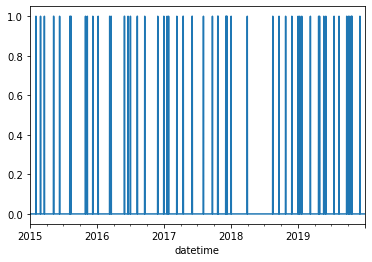

In [10]:
df_down.cleaning_event.plot()